# Training sentiment model

Now that we have cleaned up our data. It is time for us to build and train a sentiment-analysis model.

In [1]:
import re

import pandas               as pd
import matplotlib.pyplot    as plt

import tensorflow           as tf
import tensorflow_hub       as hub
import tensorflow_text      as text
import numpy                as np

from os                         import listdir
from os.path                    import isfile, join
from sklearn.model_selection    import train_test_split
from sklearn.metrics            import confusion_matrix
from sklearn.metrics            import f1_score

plt.style.use("ggplot")

### Load and explore the data

In [2]:
data = pd.read_csv("C:\\Users\\DANIEL\\Desktop\\ITSENSE\\Vertikal\\Datasets\\Social\\Processed\\sentiment_data_cleaned_no_stem.csv")

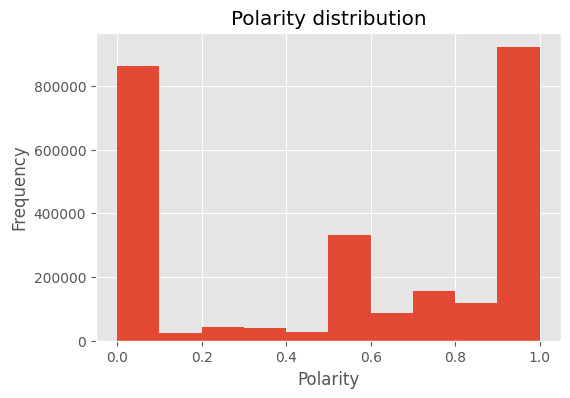

In [3]:
fig, ax = plt.subplots(figsize=(6,4))
data["sentiment"].plot(kind="hist",
                         ax=ax)

ax.set(title="Polarity distribution",
       xlabel="Polarity",
       ylabel="Frequency");

One can see that the data is skewed towards the extremes (0 and 1) and it is slightly favouring the positive sentiment.

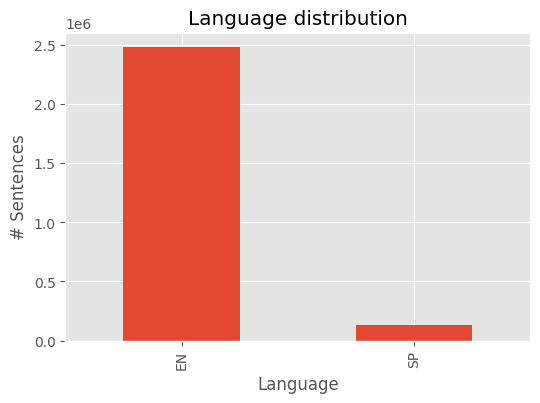

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
data["language"].value_counts().plot(kind="bar",
                                   ax=ax)

ax.set(title="Language distribution",
       xlabel="Language",
       ylabel="# Sentences");

There is an overwhelming English/Spanish ratio. We must take this into account if the results do not suffice our expectations.

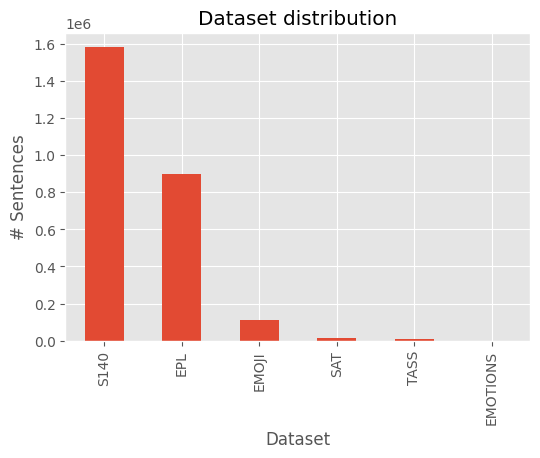

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
data["dataset"].value_counts().plot(kind="bar",
                                   ax=ax)

ax.set(title="Dataset distribution",
       xlabel="Dataset",
       ylabel="# Sentences");

### Split the data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data["content"], data["sentiment"], random_state=42, test_size=0.2)

train_data = data.loc[X_train.index]
test_data = data.loc[X_test.index]

print(f"Training set size {len(X_train)}")
print(f"Test set size {len(X_test)}")

Training set size 2089811
Test set size 522453


In [7]:
data.isna().sum()

tweet_id     0
content      0
sentiment    0
dataset      0
language     0
dtype: int64

### Start building the model

In [8]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3") #Multilingual
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4") #Multilingual

In [9]:
# Define a simple sequential model
'Bert layers'
def create_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)

  # Neural network layers
  l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(1, activation='linear', name="output")(l)

  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [l])

  #Compile Keras model
  model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_squared_error'])
  
  return model

model = create_model()

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [10]:
# checkpoint_path = "/content/drive/MyDrive/Tweets Classification/TwitterSentimentDataset-master_model_2classes_030222.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# Train the model with the new callback
model.fit(X_train, 
          y_train,
          batch_size=32,
          # callbacks=[cp_callback], # Pass callback to training
          # validation_data=(X_val, y_val),
          epochs=2)

Epoch 1/2
   56/65307 [..............................] - ETA: 178:51:46 - loss: 0.3497 - mean_squared_error: 0.3497

In [43]:
y_train = np.asarray(y_train).astype(np.float32)

In [47]:
X_train = np.asarray(X_train)

In [41]:
y_train

272501     0.50000
587106     1.00000
2277963    0.00000
822467     0.00000
1368685    0.86755
            ...   
110268     0.81845
1692743    0.26165
2356330    0.00000
2229084    0.00000
2219110    0.00000
Name: sentiment, Length: 2105122, dtype: float64